# Process RML2016.10a data
This notebook has code to import pickled data from DeepSig.io and generate a pickled dictionary ready for input into the SpectrumCNN notebook.

The dataset was generated by Tim O'Shea and Nathan West and as discussed in their paper "Radio Machine Learning Dataset Generation with GNU Radio" published in the Proceedings of the 6th GNU Radio Conference from 2016.

In [32]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

import iq_utils as iq

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

The following cell can be run to reload the iq_utils modlue after editing during notebook testing

In [ ]:
from importlib import reload
reload(iq)

## Generate data dictionary

The following cell sets the lowest SNR.

In [2]:
snr_low_thresh = 8

In [105]:
filename = "RML2016_10a_dict.pkl"
raw_data = iq.load_data(filename)
_, snrs = iq.get_mods_and_snrs(raw_data)
# snrs = [x for x in snrs if x >= snr_low_thresh]

snrs = [18]

data_dict = iq.make_data_dict(raw_data, snrs)

n_ex = data_dict['x'].shape[0]

In [106]:
data_dict['x'].shape

(11000, 128)

In [107]:
print('There are {} examples in dataset.'.format(data_dict['x'].shape[0]))
print('Each example is a complex vector of length of {}.'.format(data_dict['x'].shape[1]))
print('There were {} SNRs used.'.format(len(snrs)))

There are 11000 examples in dataset.
Each example is a complex vector of length of 128.
There were 1 SNRs used.


### Functions for 3 channel version

In [108]:
def normalize_spectrogram_3c(x_s):
    # normalizes spectrogram between 0 and 1
    # used in 3 channel iq_to_spec
    x_s[:,:,:,0] = (x_s[:,:,:,0]-np.min(x_s[:,:,:,0])) / (np.max(x_s[:,:,:,0])-np.min(x_s[:,:,:,0]))
    x_s[:,:,:,1] = (x_s[:,:,:,1]-np.min(x_s[:,:,:,1])) / (np.max(x_s[:,:,:,1])-np.min(x_s[:,:,:,1]))
    x_s[:,:,:,2] = (x_s[:,:,:,2]-np.min(x_s[:,:,:,2])) / (np.max(x_s[:,:,:,2])-np.min(x_s[:,:,:,2]))
    return x_s


def iq_to_spec_3c(data_dict, nperseg, noverlap, n_ex=None, nfft=None):
    # creates spectrogram dict with three channels for psd, angle, and phase
    
    if n_ex == None:
        n_ex = data_dict['y'].size

    if nfft == None:
        n_f = nperseg
    else:
        n_f = nfft

    n_t = int((128-nperseg)/(nperseg-noverlap) + 1)
    
    x_s = np.zeros((n_f * n_ex, n_t, 3))
    y = []
    snr = []

    for i in range(n_ex):
        x = data_dict['x'][i]
        f, t, mag = scipy.signal.spectrogram(x,
                                             window='hann',
                                             nperseg=nperseg,
                                             noverlap=noverlap,
                                             nfft=nfft,
                                             mode='magnitude',
                                             return_onesided=False)
        
        f, t, angle = scipy.signal.spectrogram(x,
                                             window='hann',
                                             nperseg=nperseg,
                                             noverlap=noverlap,
                                             nfft=nfft,
                                             mode='angle',
                                             return_onesided=False)
        
        f, t, phase = scipy.signal.spectrogram(x,
                                             window='hann',
                                             nperseg=nperseg,
                                             noverlap=noverlap,
                                             nfft=nfft,
                                             mode='phase',
                                             return_onesided=False)
        
        x_s[i*n_f : n_f*(i + 1), :, 0] = mag
        x_s[i*n_f : n_f*(i + 1), :, 1] = angle
        x_s[i*n_f : n_f*(i + 1), :, 2] = phase
        
        y.append(data_dict['y'][i])
        snr.append(data_dict['snr'][i])

    x_s = x_s.reshape(n_ex, n_f, n_t, 3)
    y = np.array(y)
    snr = np.array(snr)

    x_s = normalize_spectrogram(x_s)

    spec_dict = {'x_s': x_s, 'y': y, 'snr': snr, 't': t, 'f': f}
                
    return spec_dict


def plot_spectrogram_3c(spec_dict, ex_num):
    # plots spectrogram for three channel dict version
    mag = spec_dict['x_s'][ex_num,:,:,0]
    angle = spec_dict['x_s'][ex_num,:,:,1]
    phase = spec_dict['x_s'][ex_num,:,:,2]
    t = spec_dict['t']
    f = spec_dict['f']
    y = spec_dict['y'][ex_num]
    snr = spec_dict['snr'][ex_num]

    plt.subplot(131)
    mag = np.reshape(mag, (mag.shape[0], mag.shape[1]))
    plt.title('Magnitude\nWaveform: ' + y + '    SNR: ' + str(snr))
#     plt.pcolormesh(10*np.log10(psd))
    plt.pcolormesh(t, 
                   fftshift(f), 
                   fftshift((mag), 
                   axes=0), 
                   cmap='jet')
    
    plt.subplot(132)
    angle = np.reshape(angle, (angle.shape[0], angle.shape[1]))
    plt.title('Angle\nWaveform: ' + y + '    SNR: ' + str(snr))
#     plt.pcolormesh(10*np.log10(angle))
    plt.pcolormesh(t, 
                   fftshift(f), 
                   fftshift((angle), 
                   axes=0), 
                   cmap='jet')
    
    plt.subplot(133)
    phase = np.reshape(phase, (phase.shape[0], phase.shape[1]))
    plt.title('Phase\nWaveform: ' + y + '    SNR: ' + str(snr))
#     plt.pcolormesh(10*np.log10(phase))
    plt.pcolormesh(t, 
                   fftshift(f), 
                   fftshift((phase), 
                   axes=0), 
                   cmap='jet')
    
    plt.show()

In [109]:
spec_dict = iq_to_spec_3c(data_dict, n_ex=n_ex, nperseg=29, noverlap=28, nfft=100)

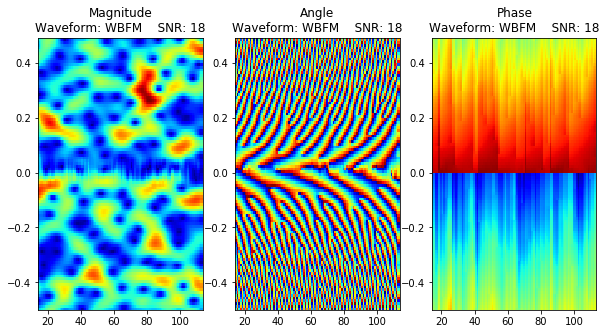

In [110]:
plot_spectrogram_3c(spec_dict, 10000)

## Generate spectrogram dictionary

In [ ]:
spec_dict = iq.iq_to_spec(data_dict, n_ex=n_ex, nperseg=29, noverlap=28, nfft=100)

In [52]:
print('There are {} examples in dataset.'.format(spec_dict['x_s'].shape[0]))
print('Spectrograms are of shape: ', spec_dict['x_s'].shape[1:])

There are 11000 examples in dataset.
Spectrograms are of shape:  (100, 100, 3)


## Set filename variable

In [ ]:
## data using SNR of 10 dB
filename = 'spectrogram_dict_10'

In [ ]:
## data using SNR from 0 to 18 dB
filename = 'spectrogram_dict_0_18'

In [ ]:
## data using SNR from -4 to 18 dB
filename = 'spectrogram_dict_n4_18'

In [ ]:
## data using SNR of 18 dB
filename = 'spectrogram_dict_18_3c'

In [11]:
## data using SNR of 2 dB
filename = 'data_dict_2'

In [111]:
## data using SNR of 18 dB
filename = 'spectrogram_dict_18_3c'

## Save as pickle file

In [112]:
iq.to_pickle(spec_dict, filename)

## Open from pickle

In [ ]:
spec_dict = iq.from_pickle('spectrogram_dict_10')

## Plot IQ data

In [ ]:
for i in range(0, n_ex, 1000):
    iq.plot_iq(data_dict, ex_num=i)

## Plot selected spectrograms

In [ ]:
n_ex = spec_dict['y'].size
x_s = spec_dict['x_s']
# x_s = np.reshape(x_s, (x_s.shape[0], x_s.shape[1], x_s.shape[2]))
x_s.shape

In [ ]:
n_ex = spec_dict['y'].size
for i in range(0, n_ex, 1000):
    iq.plot_spectrogram(spec_dict, ex_num=i)

In [ ]:
blur_dict = iq.blur_spec(spec_dict)
for i in range(0, n_ex, 1000):
    iq.plot_spectrogram(blur_dict, ex_num=i)

In [ ]:
## data using SNR of 10 dB
filename = 'spectrogram_dict_10_gauss'
iq.to_pickle(blur_dict, filename)

## Save a single sample

In [9]:
data_dict

{'x': array([[-0.00036483+0.00398386j, -0.00258631+0.00137544j,
         -0.00053151+0.01044218j, ..., -0.00304098+0.00036608j,
         -0.0011339 -0.00482608j, -0.00069634-0.01232141j],
        [ 0.00607137-0.00542144j,  0.00311698-0.00601117j,
          0.00834308-0.00648045j, ..., -0.00685108+0.00143193j,
         -0.0072343 +0.00151633j, -0.01047306-0.00449415j],
        [ 0.00539094-0.00178068j,  0.00765486+0.00184871j,
          0.00866097-0.0008065j , ..., -0.01129828+0.00125345j,
         -0.00822803+0.00454456j, -0.00851645+0.00415196j],
        ...,
        [ 0.00093115-0.00705983j,  0.00578046-0.00612658j,
          0.0034033 -0.00769688j, ...,  0.00299145-0.00640847j,
          0.00563725-0.0066769j ,  0.00563771-0.00667663j],
        [ 0.00542152-0.00585973j,  0.00223021-0.00562791j,
          0.00613159-0.00859833j, ...,  0.00157529-0.00504352j,
          0.00393293-0.00938198j,  0.00478789-0.00392715j],
        [ 0.00545507-0.00949112j,  0.00498957-0.00492554j,
        

In [10]:
data_dict['x'].shape

(11000, 128)

In [22]:
fname = '8PSK_SNR2'

In [44]:
x_c = data_dict['x'][3000]
x_c.shape

(128,)

In [18]:
def interleave(x_c):
    I = np.real(x_c)
    Q = np.imag(x_c)
    x_iq = np.empty(I.size + Q.size, dtype=np.float32)
    x_iq[0::2] = I
    x_iq[1::2] = Q
    return x_iq

x_iq = interleave(x_c)
x_iq.shape

(256,)

In [20]:
def write_to_file(filename, data):
    np.save(filename, data, allow_pickle=False)

In [23]:
write_to_file(fname, x_iq)

In [78]:
from scipy import signal
from scipy.fft import fftshift


def _normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())


def _sigma_thresh(arr, thresh):
    low_thresh, up_thresh = thresh
    sigma = np.std(arr)
    mx = np.mean(arr)
    arr = np.minimum(arr, mx + up_thresh*sigma)
    arr = np.maximum(mx - low_thresh*sigma, arr)
    return arr


def calc_spectrogram(x_c, fs, thresh, mode, nperseg, noverlap, nfft):
    f, t, sxx = signal.spectrogram(x_c, 
                                   fs, 
                                   nperseg=nperseg, 
                                   noverlap=noverlap, 
                                   nfft=nfft, 
                                   mode=mode, 
                                   return_onesided=False)

#     sxx = _sigma_thresh(sxx, thresh)
#     sxx = _normalize(sxx)

    return f, t, sxx


def plot_spectrogram(f, t, sxx, center_freq):
    offset = center_freq - f[-1]

    plt.pcolormesh(t, 
                   fftshift(f) + offset, 
                   fftshift((sxx), 
                   axes=0), 
                   cmap='jet')#,
                   # norm=LogNorm(.1, .5))

    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.show()

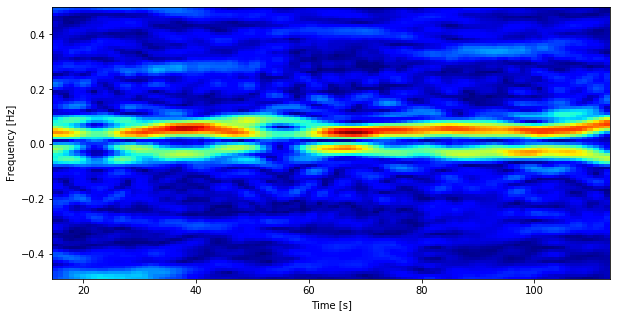

In [79]:
x_c = data_dict['x'][3000]
f, t, sxx = calc_spectrogram(x_c, 1, [3, 3], 'magnitude', 29, 28, 100)
plot_spectrogram(f, t, sxx, 0)

In [77]:
np.mean(sxx)

0.15371709